In [1]:
import sys
import os
sys.setrecursionlimit(10000)

from pywnxml.WNQuery import WNQuery
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
query = WNQuery("plwordnet-3.1-visdisc.xml", log=open(os.devnull, "w"))
query.writeStats(sys.stdout)

PoS		#synsets	#word senses	#words
Nouns		132398		176779		134778
Verbs		27693		38564		19595
Adjectives	11256		14035		8006
Adverbs		0		0		0


In [3]:
# 3

for s in query.lookUpLiteral("szkoda", "n"):
    print(s.toString())

PLWN-00003675-n  {strata:1, utrata:1, szkoda:2, uszczerbek:1}  ()
PLWN-00006533-n  {szkoda:1}  (brak danych)


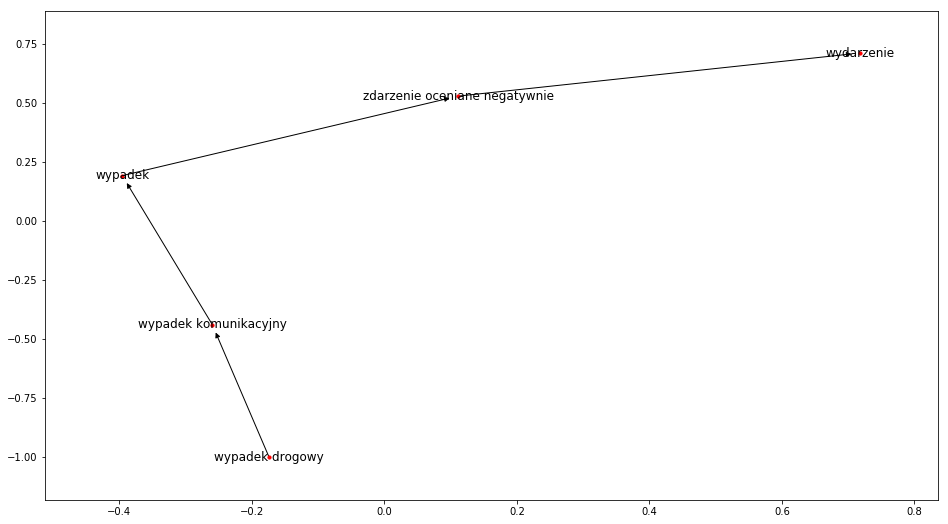

In [4]:
# 4

def fill_dg(dg, synset_id, pos, relation):
    synset = query.getSynset(synset_id, pos)
    
    dg.add_node(synset.synonyms[0].literal)
    in_relation = query.lookUpRelation(synset.wnid, synset.pos, relation) 
    for r in in_relation:
        fill_dg(dg, r, pos, relation)
        dg.add_edge(synset.synonyms[0].literal, query.getSynset(r, pos).synonyms[0].literal)

    
traffic_accident = query.lookUpSense("wypadek drogowy", 1, "n")

dg=nx.DiGraph()
fill_dg(dg, traffic_accident.wnid,  traffic_accident.pos, "hypernym")

pos = nx.spring_layout(dg)
plt.figure(figsize=(16, 9))

nx.draw_networkx_nodes(dg, pos, node_size = 10)
nx.draw_networkx_edges(dg, pos, arrows=True, width=1)
nx.draw_networkx_labels(dg, pos)
plt.show()

In [5]:
# 5
accident = query.lookUpSense("wypadek", 1, "n")
in_relation = query.lookUpRelation(accident.wnid, accident.pos, "hiponimia") 

for r in in_relation:
    print(query.getSynset(r, accident.pos).toString())

PLWN-00006486-n  {kolizja:2}  ()
PLWN-00034689-n  {tąpnięcie:1}  ()
PLWN-00034688-n  {zawał:2}  ()
PLWN-00001284-n  {zderzenie:2, kraksa:1}  ()
PLWN-00258639-n  {wykolejenie:2}  ()
PLWN-00389170-n  {zakrztuszenie:1, zachłyśnięcie:1, aspiracja:3}  ()
PLWN-00410901-n  {wypadek komunikacyjny:1}  ()
PLWN-00411618-n  {katastrofa budowlana:1}  ()
PLWN-00436137-n  {wypadek jądrowy:1}  ()
PLWN-00016131-n  {karambol:1}  ()
PLWN-00241026-n  {kapotaż:1}  ()


In [6]:
#6
accident = query.lookUpSense("wypadek", 1, "n")
in_relation = query.lookUpRelation(accident.wnid, accident.pos, "hiponimia") 

for first in  in_relation:
    for second in query.lookUpRelation(first, accident.pos, "hiponimia"):
        print(query.getSynset(second, accident.pos).toString())

PLWN-00441365-n  {kolizja drogowa:1}  ()
PLWN-00037295-n  {obwał:1}  ()
PLWN-00235346-n  {czołówka:9, zderzenie czołowe:1}  ()
PLWN-00471555-n  {stłuczka:1}  ()
PLWN-00410902-n  {wypadek drogowy:1}  ()


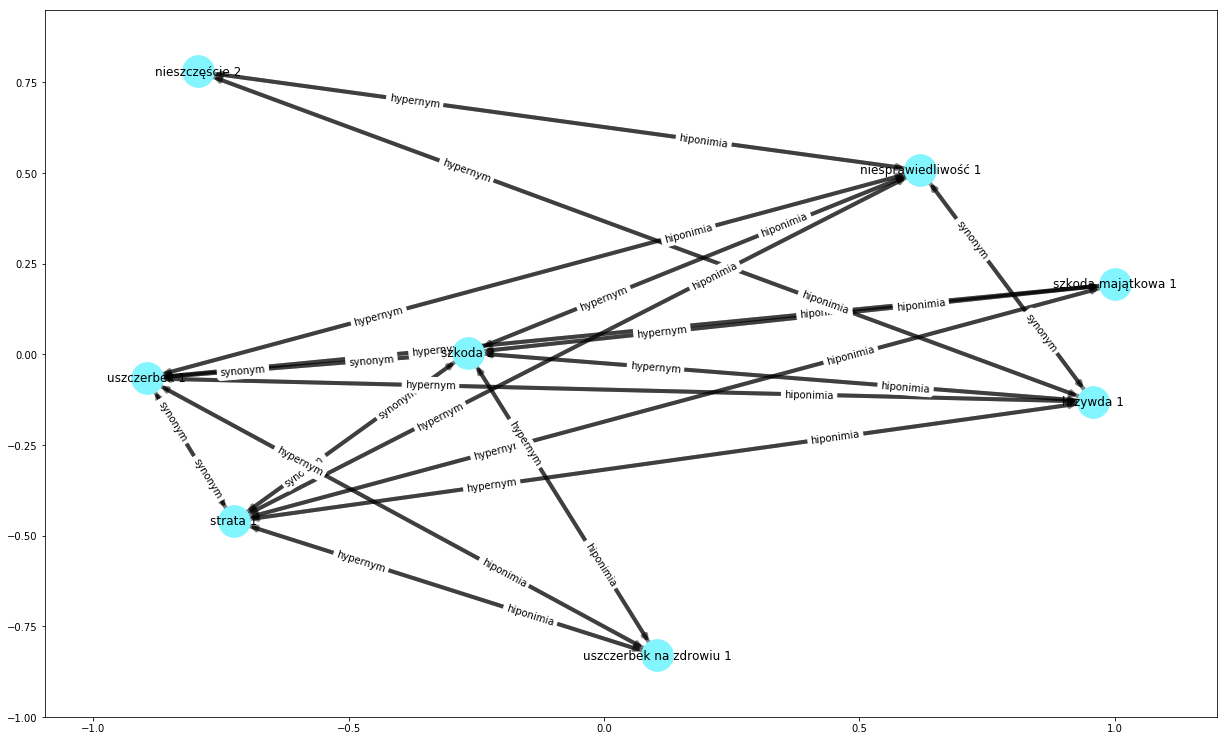

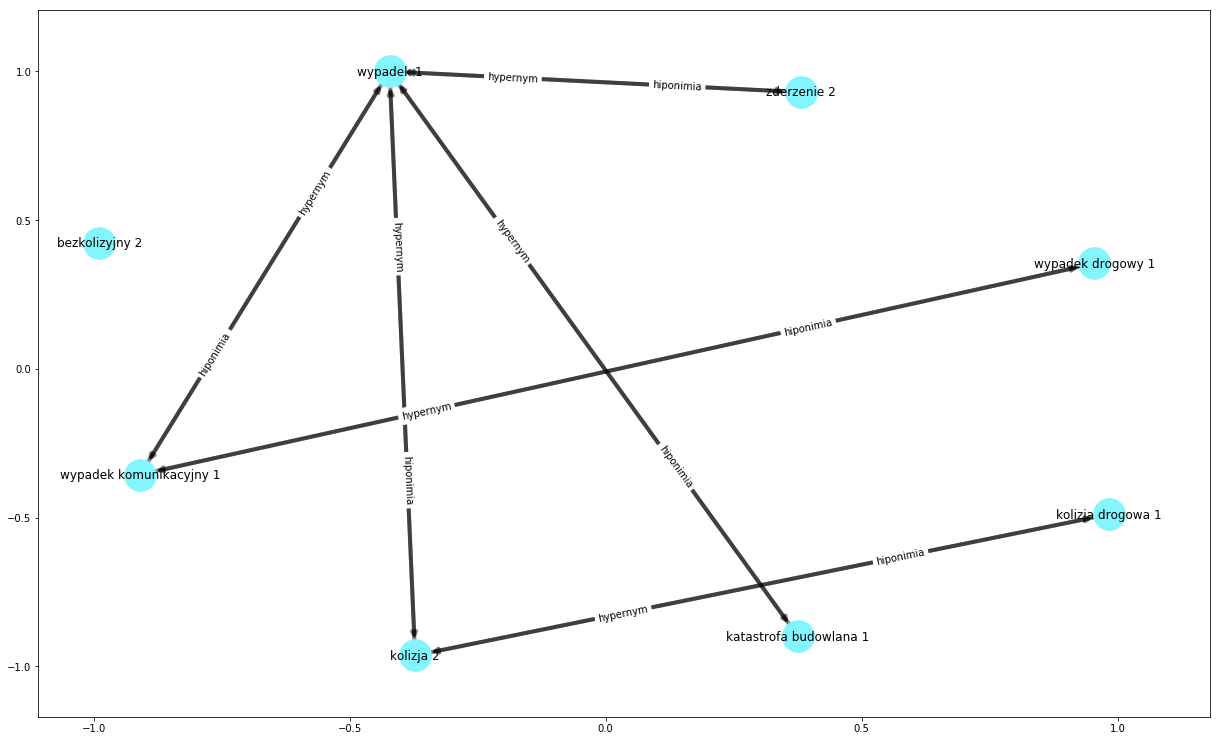

In [7]:
#7
groups = [
    "szkoda2, strata1, uszczerbek1, szkoda majątkowa1, uszczerbek na zdrowiu1, krzywda1, niesprawiedliwość1, nieszczęście2",
    "wypadek1, wypadek komunikacyjny1, kolizja2, zderzenie2, kolizja drogowa1, bezkolizyjny2, katastrofa budowlana1, wypadek drogowy1"
]
groups = [[(w[:-1], int(w[-1])) for w in g_str.split(", ")] for g_str in groups]

for group in groups:    
    dg=nx.DiGraph()
    
    def node_name(word, n ):
        return f"{word} {n}"
    
    for (word, n) in group:
        dg.add_node(node_name(word,n ))
        
    for (word, n) in group:
        for (second_word, second_n) in group:
                if (word, n)  == (second_word, second_n):
                    continue
                    
                word_synset = query.lookUpSense(word, n, "n")
                second_word_synset = query.lookUpSense(second_word, second_n, "n")
                
                try:
                    if word_synset.wnid == second_word_synset.wnid:
                        dg.add_edge(node_name(word, n), node_name(second_word, second_n), relation="synonym", weight=100)
                        continue
                except Exception as e:
                    continue
                    
                for ilr in  word_synset.ilrs:
                    if ilr[0] == second_word_synset.wnid:
                            dg.add_edge(node_name(word, n), node_name(second_word, second_n), relation=ilr[1], weight=1)
                            break

                
    plt.figure(figsize=(21, 13))

    pos = nx.spring_layout(dg, k=5)

    node_size = 1000
    nx.draw_networkx_nodes(dg, pos, node_size=node_size, node_color="#82f5ff")
    nx.draw_networkx_edges(dg, pos, node_size=node_size, arrows=True, width=4, arrowsize=10, alpha=0.5)
    
    edge_labels = nx.get_edge_attributes(dg ,'relation')
    nx.draw_networkx_edge_labels(dg, pos, node_size=node_size, edge_labels=edge_labels, label_pos=0.3)

    nx.draw_networkx_labels(dg, pos)

    plt.show()
    

In [9]:
groups = [
    "szkoda2 - wypadek1",
    "kolizja2 - szkoda majątkowa1",
    "nieszczęście2 - katastrofa budowlana1"
]
groups = [[(w[:-1], int(w[-1])) for w in g_str.split(" - ")] for g_str in groups]

for (g_1, g_2) in groups:
    id_1 = query.lookUpSense(g_1[0], g_1[1], "n").wnid
    id_2 = query.lookUpSense(g_2[0], g_2[1], "n").wnid

    lea_cho = query.simLeaCho(id_1, id_2, "n")
    print((g_1, g_2), lea_cho)

(('szkoda', 2), ('wypadek', 1)) 1.1249387366083
(('kolizja', 2), ('szkoda majątkowa', 1)) 0.9030899869919435
(('nieszczęście', 2), ('katastrofa budowlana', 1)) 0.8239087409443188
